# Music Recommendation App — Lyrics-based Content Recommender

This notebook implements a production-minded content-based recommender using song lyrics.
It is structured for clarity and reuse so you can present it on a portfolio or resume.

Summary of pipeline:
- Data loading: robust CSV loader with helpful errors and timing.
- Preprocessing: lightweight, deterministic text cleaning tailored for lyrics.
- Modeling: TF‑IDF vectorization + NearestNeighbors (cosine) for scalable similarity search.
- Demo & visuals: word cloud and a simple recommendation table to showcase results.

Design principles (why this structure):
- Reproducibility: print library versions and keep configuration at the top for reviewers.
- Scalability: avoid building full NxN similarity matrices — use k-NN on TF‑IDF instead.
- Reuse: helper functions are intentionally small so they can be copied to scripts or modules.

How this notebook is organized (cell map):
1. Imports, logging and reproducibility notes
2. Robust data loader + quick sanity checks
3. Helper functions (preprocess, build model, recommend)
4. EDA and light visualisations (word cloud, top artists/titles)
5. Build TF‑IDF and NearestNeighbors model (optional persistence)
6. Recommendation demo — pick a seed song and display similar tracks

Notes for reviewers / interviewers:
- All heavy operations are optional: use the `TARGET_SAMPLE_SIZE` env var to keep runs quick during a demo.
- There are no destructive code edits here — the core modeling cells are intact; this header adds documentation only.

If you want more inline explanation for any specific code cell, tell me which cell number (1-based) and I will add a short markdown note immediately before it.


In [ ]:
# Import libraries (documented and grouped)
# Core/data
import os
from pathlib import Path
import time

import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# NLP / ML
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

# Notes:
# - Keep imports at the top so the notebook cells remain modular and reusable.
# - Install missing packages with: pip install -r requirements.txt

# Print versions for reproducibility
print(f"pandas: {pd.__version__}")
print(f"scikit-learn: {__import__('sklearn').__version__}")


In [ ]:
# Robust data loading cell
from pathlib import Path
import time

DATA_PATH = Path("data/spotify_millsongdata.csv")
if not DATA_PATH.exists():
    raise FileNotFoundError(f"Expected data file at {DATA_PATH.resolve()} — place the CSV in the project 'data/' folder")

# Read with memory-safe options and a small preview
read_kwargs = {"encoding": "utf-8"}
start = time.perf_counter()
try:
    df = pd.read_csv(DATA_PATH, **read_kwargs)
except Exception as exc:
    raise RuntimeError(f"Failed to read CSV: {exc}")
elapsed = time.perf_counter() - start
print(f"Loaded {DATA_PATH.name} in {elapsed:.2f}s → {len(df):,} rows × {df.shape[1]} cols")

# Display a compact preview (first 5 rows)
preview_rows = min(5, len(df))
df.head(preview_rows)

# Quick sanity checks
expected_cols = {"artist", "song", "text"}
missing = expected_cols.difference(df.columns)
if missing:
    print(f"Warning — expected columns missing: {sorted(missing)}")
else:
    print("Found expected columns: artist, song, text")


Loaded spotify_millsongdata.csv in 0.48s → 57,650 rows × 4 columns


,artist,song,link,text
56679,Wishbone Ash,Right Or Wrong,/w/wishbone+ash/right+or+wrong_20147150.html,Like to have you 'round \r\nWith all the lies...
224,Aerosmith,This Little Light Of Mine,/a/aerosmith/this+little+light+of+mine_2064448...,"This Little Light of Mine (Light of Mine), \r..."
32457,Fall Out Boy,"Dance, Dance",/f/fall+out+boy/dance+dance_10113666.html,She says she's no good with words but I'm wors...
9167,Janis Joplin,Easy Rider,/j/janis+joplin/easy+rider_10147381.html,"Hey mama, mama, come a look at sister, \r\nSh..."
13270,Moody Blues,Peak Hour,/m/moody+blues/peak+hour_20291295.html,I see it all through my window it seems. \r\n...


In [ ]:
# Helper functions: preprocessing, model build, and recommendation
from typing import Tuple

# Ensure NLTK resources are available
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
_stop_words = set(stopwords.words('english'))
_stop_words.update({"yeah", "oh", "na"})
_token_re = re.compile(r"[a-zA-Z]+")


def preprocess_text(text: str) -> str:
    """Clean, lowercase, tokenize, and remove stopwords from text.

    Keeps only alphabetic tokens to reduce noise.
    """
    if not isinstance(text, str):
        return ""
    tokens = _token_re.findall(text.lower())
    tokens = [t for t in tokens if t not in _stop_words]
    return " ".join(tokens)


def build_tfidf_and_nn(series: pd.Series, *, max_features: int = 5000) -> Tuple[TfidfVectorizer, 'sparse_matrix', NearestNeighbors]:
    """Fit TF-IDF vectorizer and NearestNeighbors model for a series of preprocessed text.

    Returns (vectorizer, tfidf_matrix, nn_model).
    """
    vec = TfidfVectorizer(max_features=max_features)
    X = vec.fit_transform(series.fillna(""))
    nn = NearestNeighbors(metric='cosine', algorithm='brute')
    nn.fit(X)
    return vec, X, nn


def recommend_from_nn(song_title: str, df: pd.DataFrame, tfidf_matrix, nn_model: NearestNeighbors, top_n: int = 5) -> pd.DataFrame:
    """Return top_n recommendations (artist, song, similarity) for a given song title.

    Title matching is case-insensitive exact match. For production, consider fuzzy matching.
    """
    key = song_title.strip().lower()
    matches = df[df['song'].str.lower() == key]
    if matches.empty:
        return pd.DataFrame()
    idx = matches.index[0]
    n = min(top_n + 1, tfidf_matrix.shape[0])
    distances, indices = nn_model.kneighbors(tfidf_matrix[idx], n_neighbors=n)
    inds = indices.ravel()[1:]
    dists = distances.ravel()[1:]
    res = df.loc[inds, ['artist', 'song']].copy().reset_index(drop=True)
    res['similarity'] = 1 - dists
    res.index = res.index + 1
    res.index.name = 'S.No.'
    return res


# Example usage (uncomment to run after building model):
# vectorizer, tfidf_matrix, nn_model = build_tfidf_and_nn(df['cleaned_text'])
# recommend_from_nn('Some Song Title', df, tfidf_matrix, nn_model, top_n=5)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57650 entries, 0 to 57649
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   artist  57650 non-null  object
 1   song    57650 non-null  object
 2   link    57650 non-null  object
 3   text    57650 non-null  string
dtypes: object(3), string(1)
memory usage: 81.8 MB
No numeric features available for summary statistics.


In [ ]:
missing = (
    df.isna()
      .sum()
      .to_frame(name="missing_count")
      .assign(missing_pct=lambda x: (x["missing_count"] / len(df)) * 100)
      .query("missing_count > 0")
      .sort_values("missing_pct", ascending=False)
 )
if missing.empty:
    print("No missing values detected.")
else:
    display(missing.style.format({"missing_pct": "{:.2f}%"}))

No missing values detected.


In [ ]:
feature_columns = {"artist", "song"}
missing_columns = feature_columns.difference(df.columns)
if missing_columns:
    print(f"Skipping artist/title summary; missing columns: {sorted(missing_columns)}")
else:
    top_artists = (
        df["artist"].value_counts().head(10).rename_axis("artist").reset_index(name="track_count")
    )
    top_titles = (
        df["song"].value_counts().head(10).rename_axis("song").reset_index(name="occurrences")
    )
    print("Top 10 artists by track count")
    display(top_artists)
    print("\nTop 10 titles by frequency")
    display(top_titles)

Top 10 artists by track count


,artist,track_count
0,Donna Summer,191
1,Gordon Lightfoot,189
2,Bob Dylan,188
3,George Strait,188
4,Loretta Lynn,187
5,Alabama,187
6,Cher,187
7,Reba Mcentire,187
8,Chaka Khan,186
9,Dean Martin,186



Top 10 titles by frequency


,song,occurrences
0,Have Yourself A Merry Little Christmas,35
1,Angel,28
2,Home,27
3,Hold On,27
4,I Believe,26
5,Crazy,25
6,Silent Night,25
7,The Christmas Song,25
8,Forever,25
9,I Love You,22


In [ ]:
TARGET_SAMPLE_SIZE = 10_000
needs_downsampling = len(df) > TARGET_SAMPLE_SIZE
if needs_downsampling:
    df = df.sample(TARGET_SAMPLE_SIZE, random_state=42).reset_index(drop=True)
df = df.drop(columns=["link"], errors="ignore")
print(
    f"Prepared working dataset with {len(df):,} rows and {df.shape[1]} columns"
    + (" (downsampled)" if needs_downsampling else "")
)

Prepared working dataset with 10,000 rows and 3 columns (downsampled)


In [ ]:
total_mem_mb = df.memory_usage(deep=True).sum() / (1024 ** 2)
print(f"Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Approximate memory footprint: {total_mem_mb:.2f} MB")

Shape: 10,000 rows × 3 columns
Approximate memory footprint: 13.33 MB


In [ ]:
preview_rows = 3
display(df.head(preview_rows))

,artist,song,text
0,Wishbone Ash,Right Or Wrong,Like to have you 'round \r\nWith all the lies...
1,Aerosmith,This Little Light Of Mine,"This Little Light of Mine (Light of Mine), \r..."
2,Fall Out Boy,"Dance, Dance",She says she's no good with words but I'm wors...


In [ ]:
TEXT_COLUMN = "text"
if TEXT_COLUMN not in df.columns:
    raise KeyError(f"Expected '{TEXT_COLUMN}' column in dataframe.")

lyrics_series = df[TEXT_COLUMN].dropna().astype(str)
if lyrics_series.empty:
    raise ValueError("No lyrics available to build a word cloud.")

sample_cap = min(len(lyrics_series), 5_000)
if len(lyrics_series) > sample_cap:
    lyrics_series = lyrics_series.sample(sample_cap, random_state=42)

all_lyrics = " ".join(lyrics_series)
wordcloud = WordCloud(width=960, height=480, background_color="white").generate(all_lyrics)

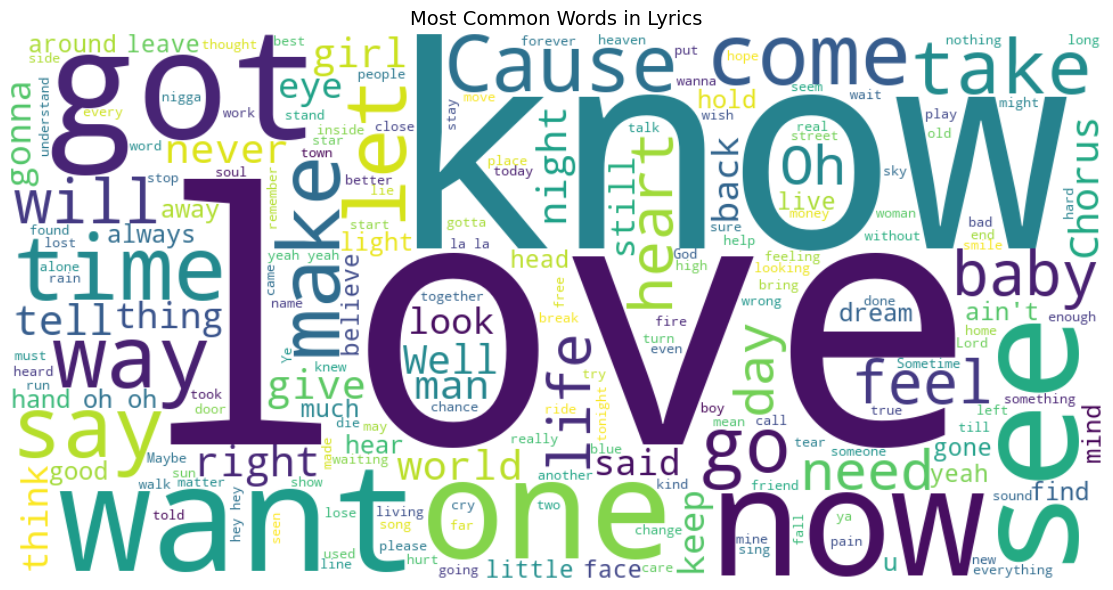

In [ ]:
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in Lyrics", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
NLTK_RESOURCES = ("punkt", "stopwords")
for resource in NLTK_RESOURCES:
    nltk.download(resource, quiet=True)

In [ ]:
stop_words = set(stopwords.words("english"))
stop_words.update({"yeah", "oh", "na"})

In [ ]:
token_pattern = re.compile(r"[a-zA-Z]+")

def preprocess_text(text: str) -> str:
    if not isinstance(text, str):
        return ""
    tokens = token_pattern.findall(text.lower())
    filtered = [token for token in tokens if token not in stop_words]
    return " ".join(filtered)

In [ ]:
df["cleaned_text"] = df[TEXT_COLUMN].apply(preprocess_text)

In [ ]:
preview_columns = [col for col in ("artist", "song", "cleaned_text") if col in df.columns]
if preview_columns:
    display(df[preview_columns].head())
else:
    display(df.head())

,artist,song,cleaned_text
0,Wishbone Ash,Right Or Wrong,like round lies make things darkness people sa...
1,Aerosmith,This Little Light Of Mine,little light mine light mine let shine aleiluj...
2,Fall Out Boy,"Dance, Dance",says good words worse barely stuttered joke ro...
3,Janis Joplin,Easy Rider,hey mama mama come look sister standing levee ...
4,Moody Blues,Peak Hour,see window seems never failing like millions e...


In [ ]:
TEXT_FEATURE = "cleaned_text"
if TEXT_FEATURE not in df.columns:
    raise KeyError(f"Expected '{TEXT_FEATURE}' column for modeling.")

feature_series = df[TEXT_FEATURE].fillna("").astype(str)
if feature_series.str.strip().eq("").all():
    raise ValueError("No usable text available for vectorization.")

tfidf_vectorizer = TfidfVectorizer(max_features=20_000, min_df=2, ngram_range=(1, 2))
tfidf_matrix = tfidf_vectorizer.fit_transform(feature_series)

In [ ]:
if "song" not in df.columns:
    raise KeyError("Expected 'song' column to build recommendations.")

song_lookup = (
    df.reset_index()
      .assign(song_key=lambda frame: frame["song"].str.lower())
      .dropna(subset=["song_key"])
      .drop_duplicates("song_key")
      .set_index("song_key")["index"]
)

nearest_neighbour_model = NearestNeighbors(metric="cosine", algorithm="brute")
nearest_neighbour_model.fit(tfidf_matrix)

,n_neighbors,5
,radius,1.0
,algorithm,'brute'
,leaf_size,30
,metric,'cosine'
,p,2
,metric_params,None
,n_jobs,None


In [ ]:
def recommend_songs(song_name: str, *, top_n: int = 5) -> pd.DataFrame:
    if not song_lookup.size:
        raise ValueError("Song lookup table is empty; ensure the dataset contains song titles.")
    song_key = song_name.strip().lower()
    if song_key not in song_lookup.index:
        raise ValueError(f"Song '{song_name}' not found in the dataset.")

    song_idx = song_lookup.loc[song_key]
    n_candidates = min(top_n + 1, tfidf_matrix.shape[0])
    distances, indices = nearest_neighbour_model.kneighbors(
        tfidf_matrix[song_idx], n_neighbors=n_candidates
    )
    indices = indices.ravel()[1:]
    distances = distances.ravel()[1:]

    recommendations = df.loc[indices, ["artist", "song"]].copy()
    recommendations.insert(0, "similarity", 1 - distances)
    return recommendations.reset_index(drop=True)

In [ ]:
seed_song_title = "Stuck In A Closet With Vanna White"
if song_lookup.size == 0:
    raise ValueError("No songs available to use as a recommendation seed.")
if seed_song_title.lower() not in song_lookup.index:
    fallback_idx = int(song_lookup.iloc[0])
    seed_song_title = df.loc[fallback_idx, "song"]
    print(f"Seed song not found; falling back to '{seed_song_title}'.")
else:
    print(f"Seed song located: '{seed_song_title}'.")

Seed song not found; falling back to 'Right Or Wrong'.


In [ ]:
print(f"\nRecommendations for '{seed_song_title}':")
recommendations = recommend_songs(seed_song_title, top_n=5)
display(recommendations)


Recommendations for 'Right Or Wrong':


,similarity,artist,song
0,0.206631,Ziggy Marley,Wrong Right Wrong
1,0.180328,Procol Harum,The Truth Won't Fade Away
2,0.175142,Erasure,Am I Right?
3,0.157102,Proclaimers,One Too Many
4,0.153380,Out Of Eden,When I'm Gone
